# Homework 2 

## General block 

In [47]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
setX = pd.read_excel("X_4_16.xlsx", engine='openpyxl')
setY = pd.read_excel("Y_4_16.xlsx", engine='openpyxl')

### Choisen distance = Manhhaten

In [49]:
def getDistMatrix(dataset):
    matrix_condensed = scipy.spatial.distance.pdist(dataset, metric='cityblock')
    dist_matrix = scipy.spatial.distance.squareform(matrix_condensed)

    return dist_matrix, matrix_condensed

dist_matirx_X, dist_matrix_X_condenced = getDistMatrix(setX)
dist_matirx_Y, dist_matrix_Y_condenced = getDistMatrix(setY)

### Similarity matrices

In [50]:
def getSimilarityMatrix(dist_matrix):
    median = np.median(dist_matrix[dist_matrix > 0])
    betta = 1 / median
    sim_matrix = np.exp(-betta * dist_matrix)
    np.fill_diagonal(sim_matrix, 0)

    return sim_matrix

similar_matrix_X = getSimilarityMatrix(dist_matirx_X)
similar_matrix_Y = getSimilarityMatrix(dist_matirx_Y)

### Graph model + visualization (Алгоритм принудительного размещения (Force-Directed Layout), а именно его реализацию, известную как Fruchterman-Reingold (FR) Layout.)

+ добавить визуализацию при помощи PCA?


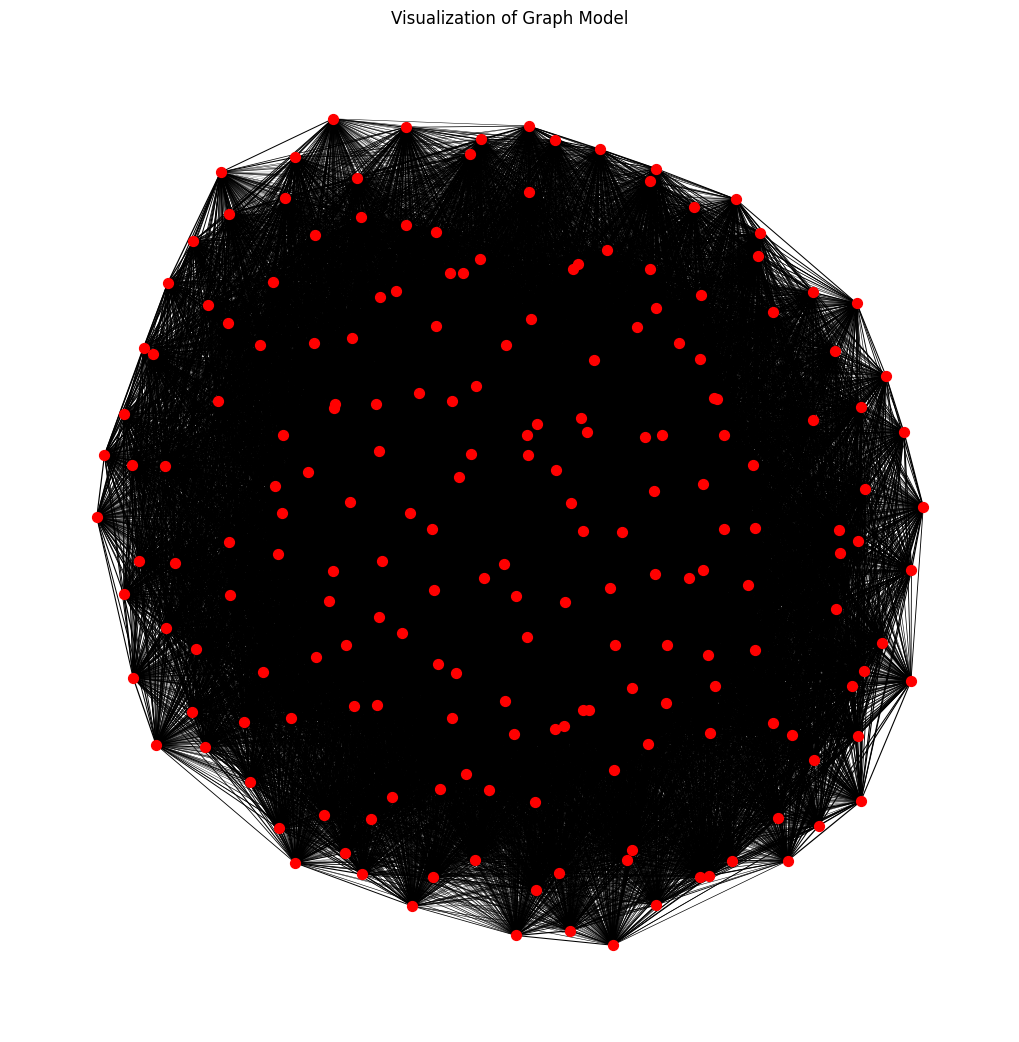

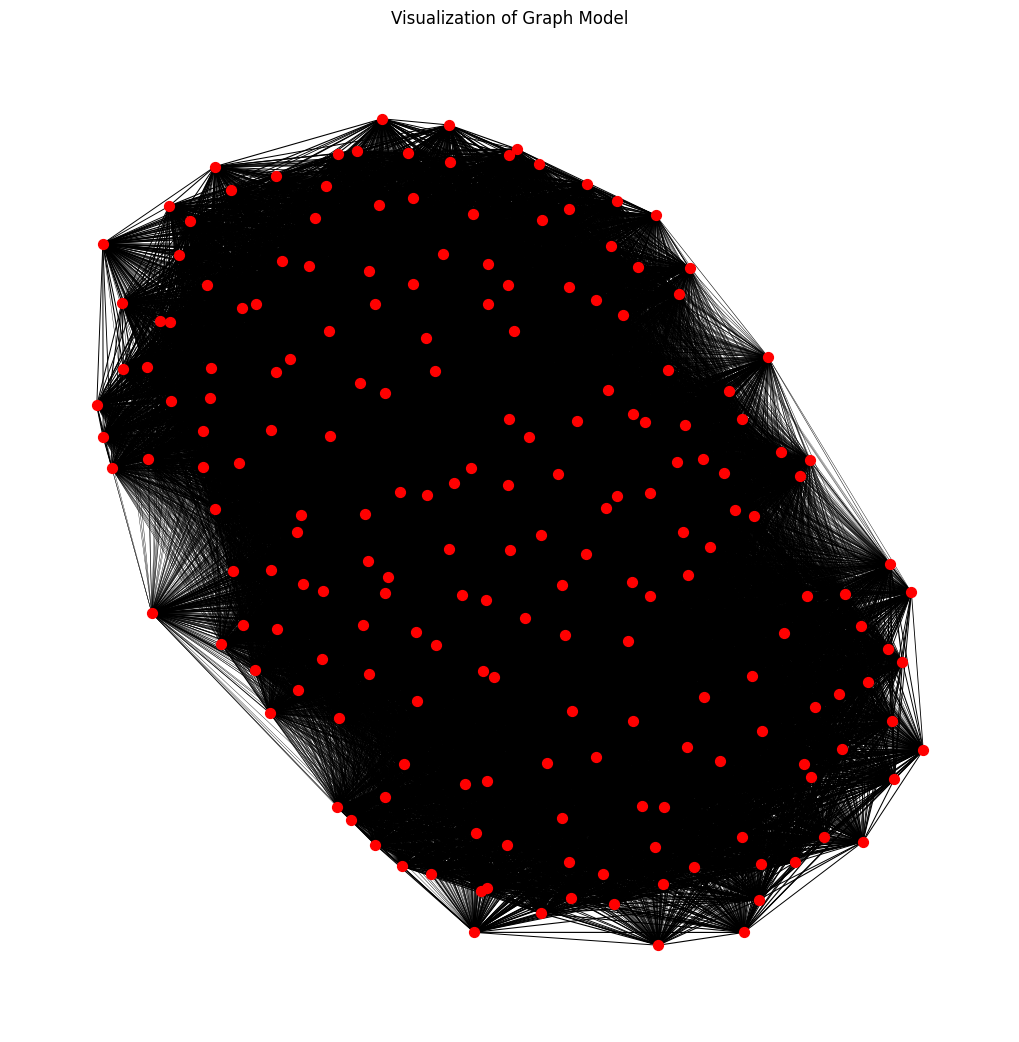

In [51]:
def plotGraph(G_full):
    pos = nx.spring_layout(G_full)

    edges = G_full.edges()
    weights = [G_full[u][v]['weight'] * 1 for u, v in edges] 

    plt.figure(figsize=(10, 10))
    nx.draw(
        G_full,
        pos,
        edge_color='black', 
        width=weights,     
        with_labels=False,  
        node_color='red',
        node_size=50
    )
    plt.title(f"Visualization of Graph Model")
    plt.show()

G_full = nx.from_numpy_array(similar_matrix_X)
G_full_Y = nx.from_numpy_array(similar_matrix_Y)

GraphModel = plotGraph(G_full)
GraphModel_Y = plotGraph(G_full_Y)

##  how can we simplify this graph?

### theshold method

+ связность графа не сохраняется, нужен иной метод

In [52]:
def theshold_method(similar_matrix, tau_in=0.8):
    tau = tau_in

    A = similar_matrix.copy()
    A[A < tau] = 0

    G_A = nx.from_numpy_array(A)


    GraphModel = plotGraph(G_A)

    return GraphModel

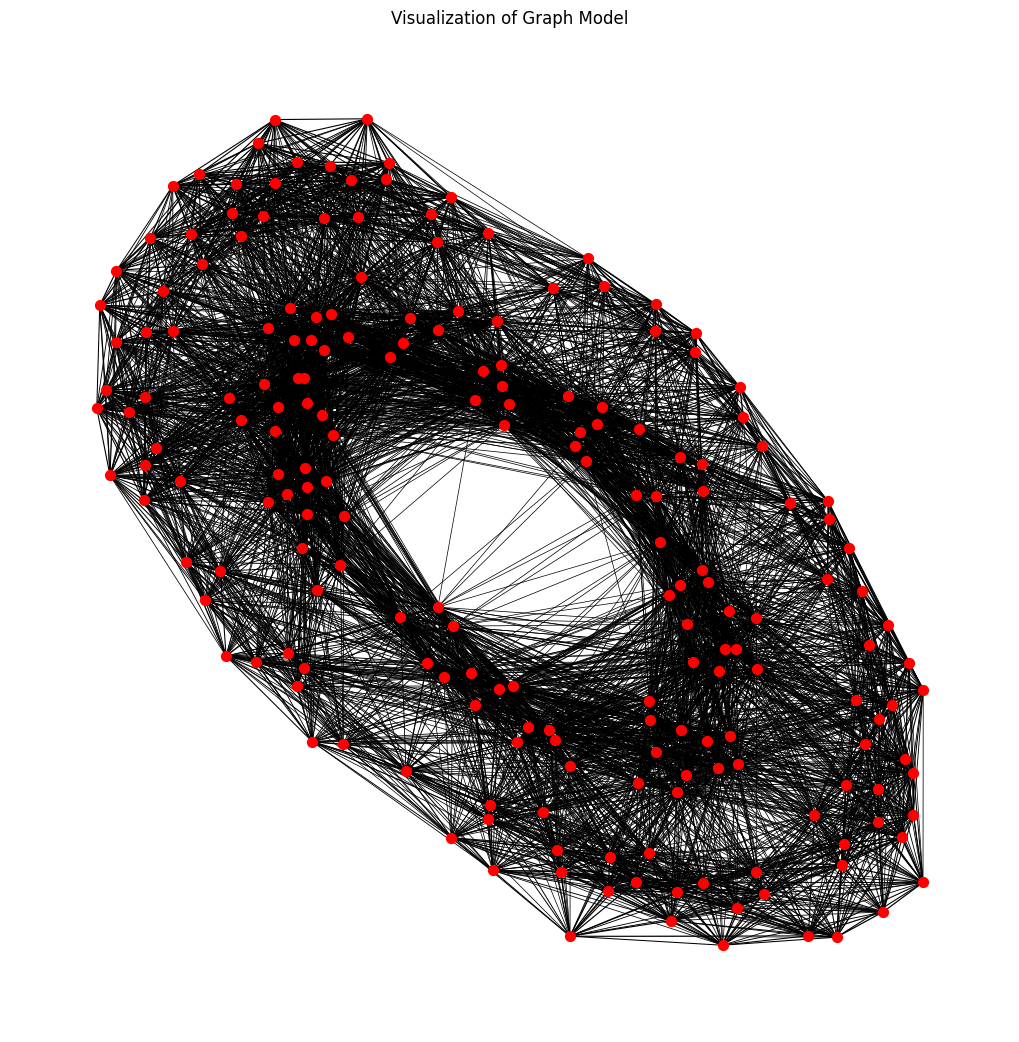

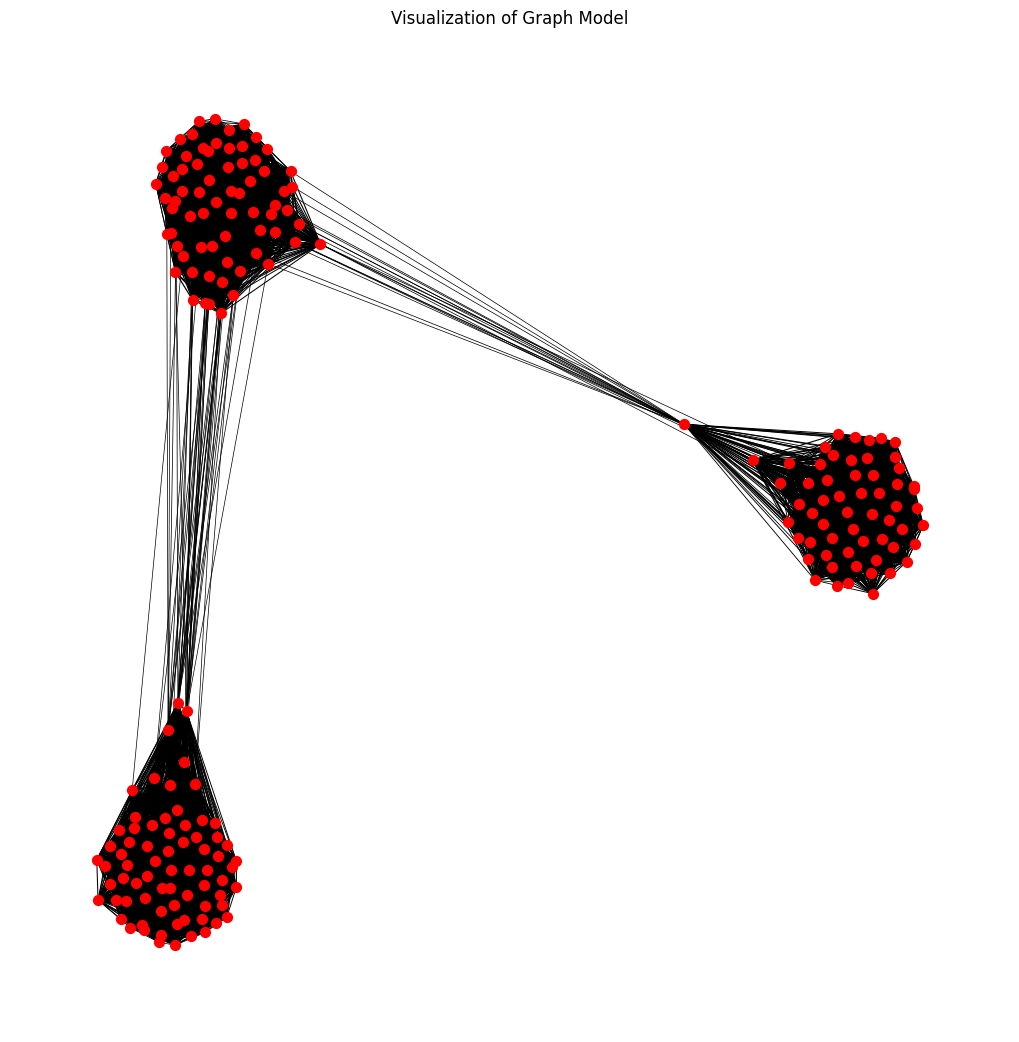

In [53]:
Thes_GM = theshold_method(similar_matrix_X, 0.5)
Thes_GM_Y = theshold_method(similar_matrix_Y, 0.5)

### MST method

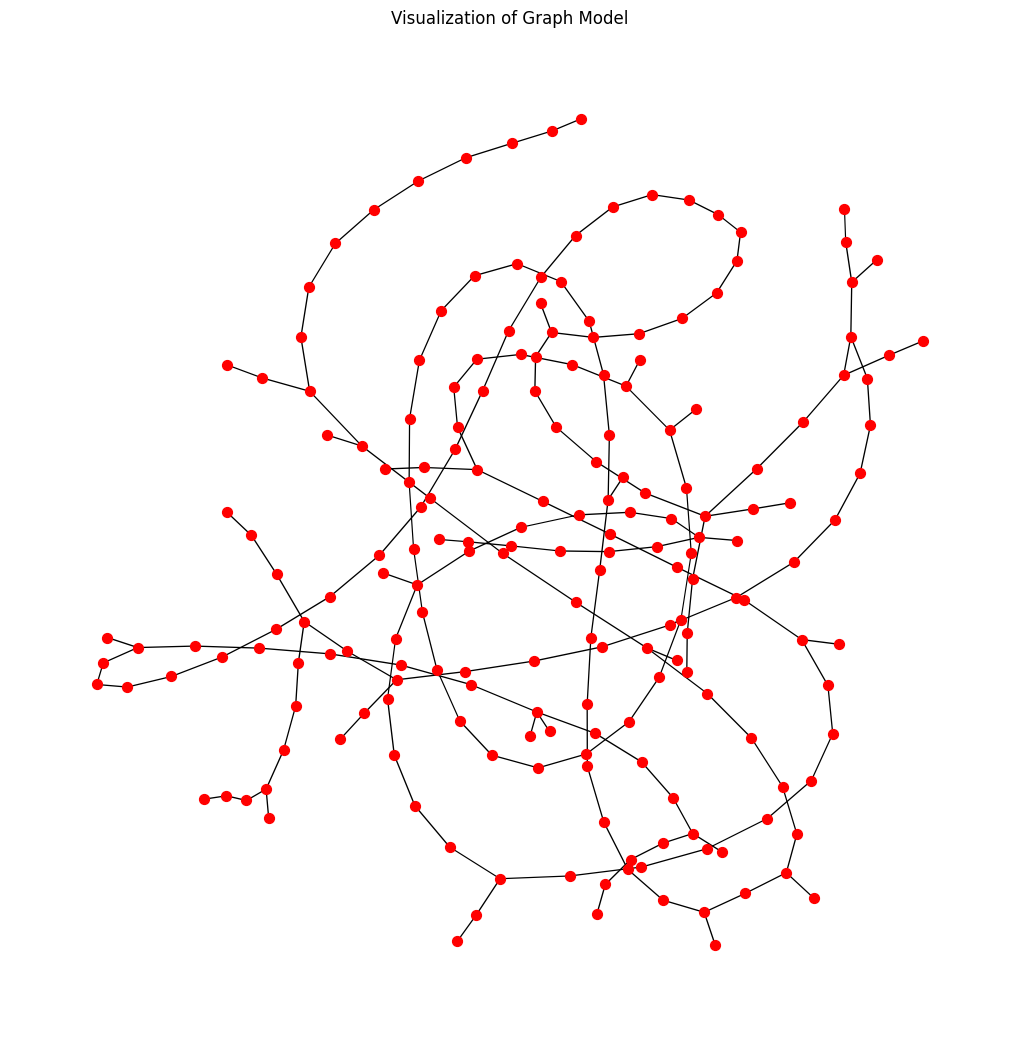

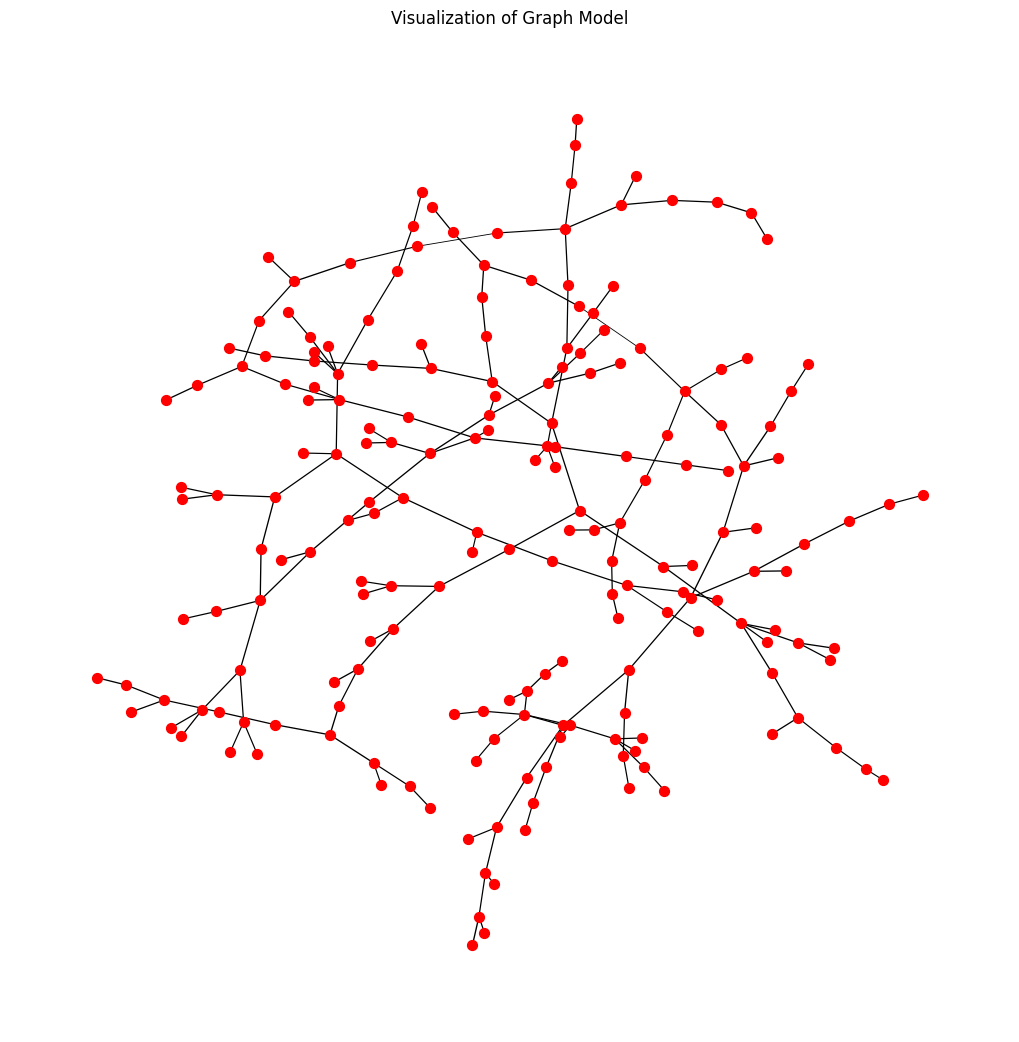

Graph with 199 nodes and 198 edges
Graph with 199 nodes and 198 edges


In [54]:
def MST_method(similar_matrix):
    mst = nx.maximum_spanning_tree(nx.from_numpy_array(similar_matrix))
    plotGraph(mst)

    return mst

MST_G = MST_method(similar_matrix_X)
MST_G_Y = MST_method(similar_matrix_Y)
print(MST_G)
print(MST_G_Y)

### PCA for visualization

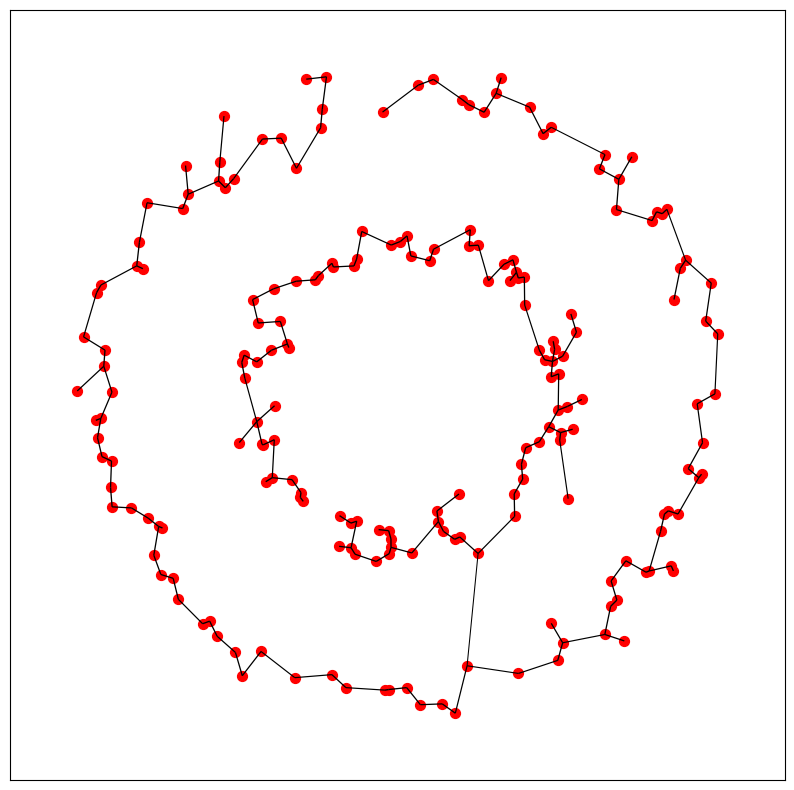

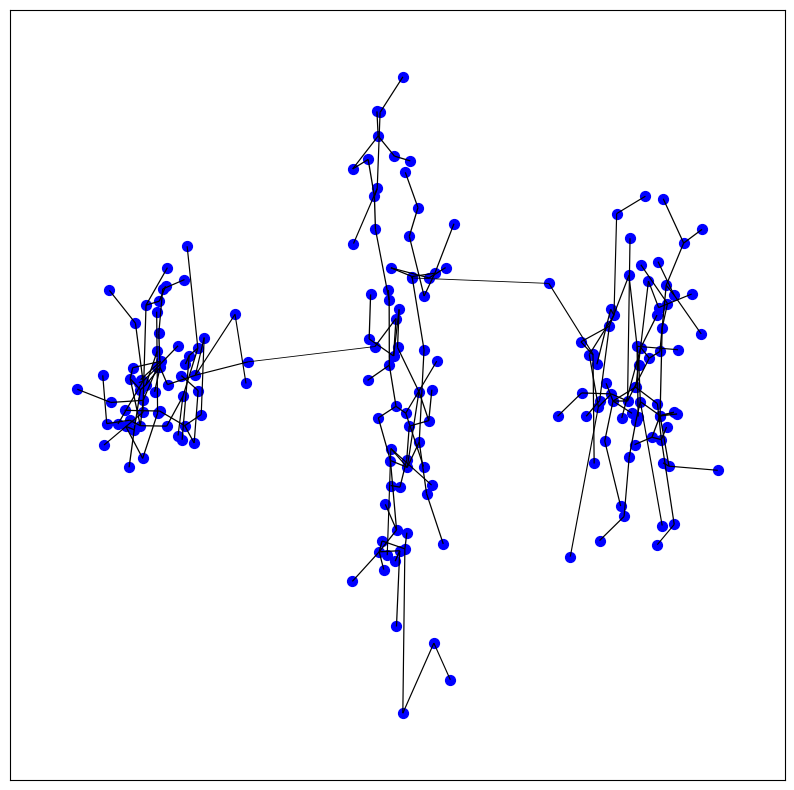

In [55]:
def PCA_(data, G_mast, clusters = None):
    data_scaled = StandardScaler().fit_transform(data)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

    pos_pca = {i: principal_components[i, :] for i in range(len(pca_df))}

    plt.figure(figsize=(10, 10))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], c = clusters, s=50) # Точки

    edges_mast = G_mast.edges(data=True)
    weights_mast = [d['weight'] * 1 for u, v, d in edges_mast] # Используем те же веса для рёбер

    nx.draw_networkx_edges(
        G_mast,
        pos=pos_pca, 
        edge_color='black',
        width=weights_mast,
        alpha=1,
    )
    
    plt.show()


PCA_(setX, MST_G, clusters='red')
PCA_(setY, MST_G_Y, clusters='blue')

## 2-clusters

+ используем ward linkage

In [56]:
Z_X = linkage(dist_matrix_X_condenced, method='ward')

Z_Y = linkage(dist_matrix_Y_condenced, method='ward')

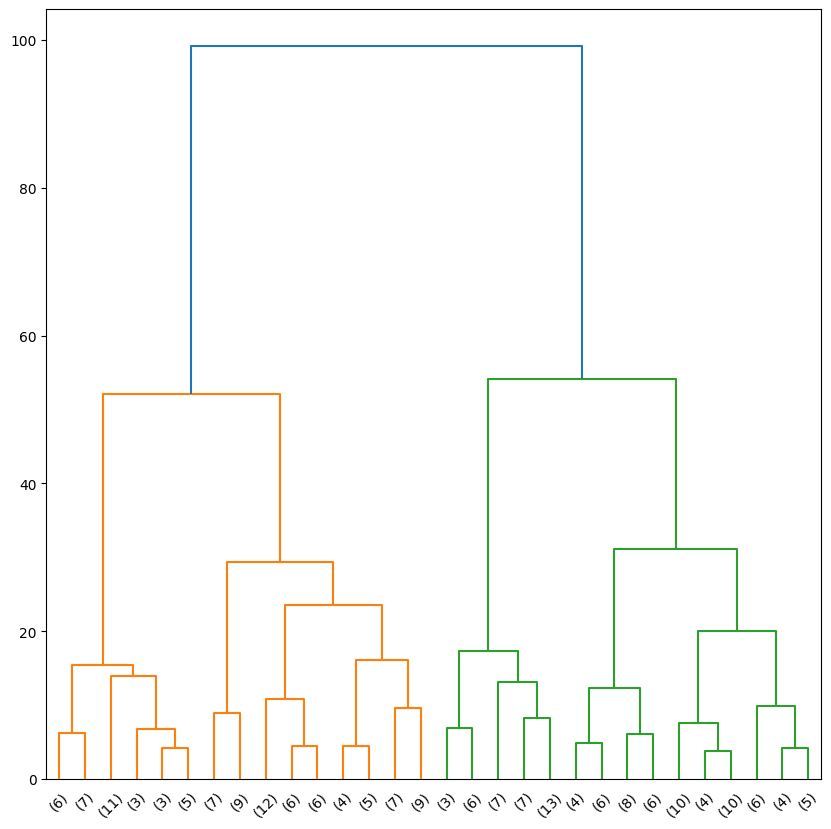

In [57]:
# dendogram
plt.figure(figsize=(10, 10))

dn = dendrogram(
    Z_X,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True
)

plt.show()

In [58]:
cluster_labels_X_ward = fcluster(Z_X, t=60, criterion='distance')

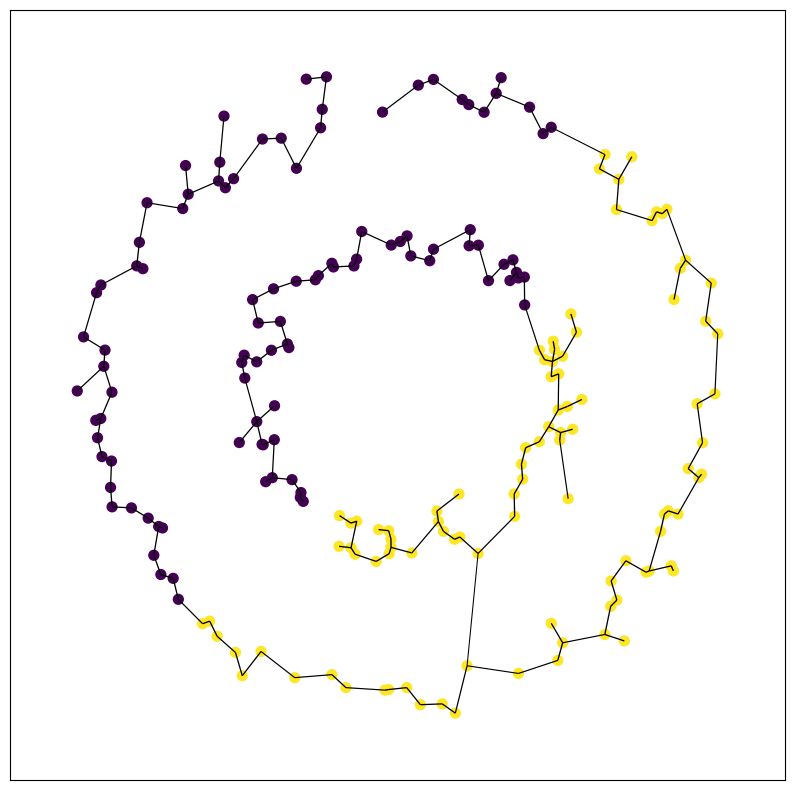

In [59]:
PCA_(setX, MST_G, cluster_labels_X_ward)

### k-means


In [60]:
k_means = KMeans(n_clusters=2, random_state=42, n_init='auto')

In [61]:
data_scaled_X = StandardScaler().fit_transform(setX)

data_scaled_Y = StandardScaler().fit_transform(setY)

In [62]:
cluster_labels_X_kmeans = k_means.fit_predict(data_scaled_X)

cluster_labels_Y_kmeans = k_means.fit_predict(data_scaled_Y)

In [63]:
print(cluster_labels_X_kmeans)

print(cluster_labels_Y_kmeans)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 0]


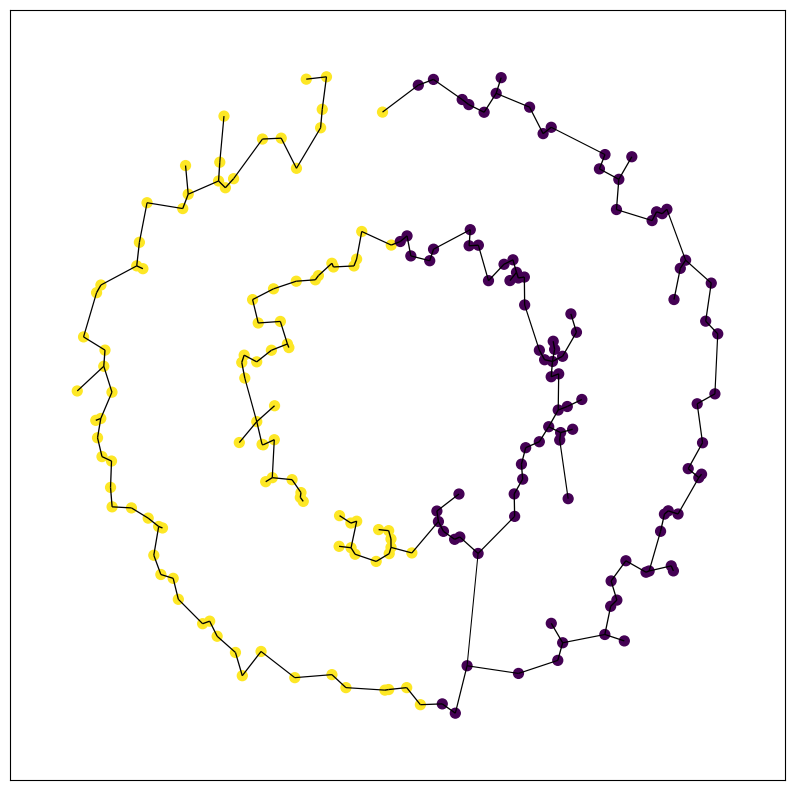

In [64]:
PCA_(setX, MST_G, cluster_labels_X_kmeans)

## EM algorithm

In [65]:
gauss_mix = GaussianMixture(n_components=2, random_state=42, n_init=10)

In [66]:
cluster_labels_X_EM = gauss_mix.fit_predict(data_scaled_X)

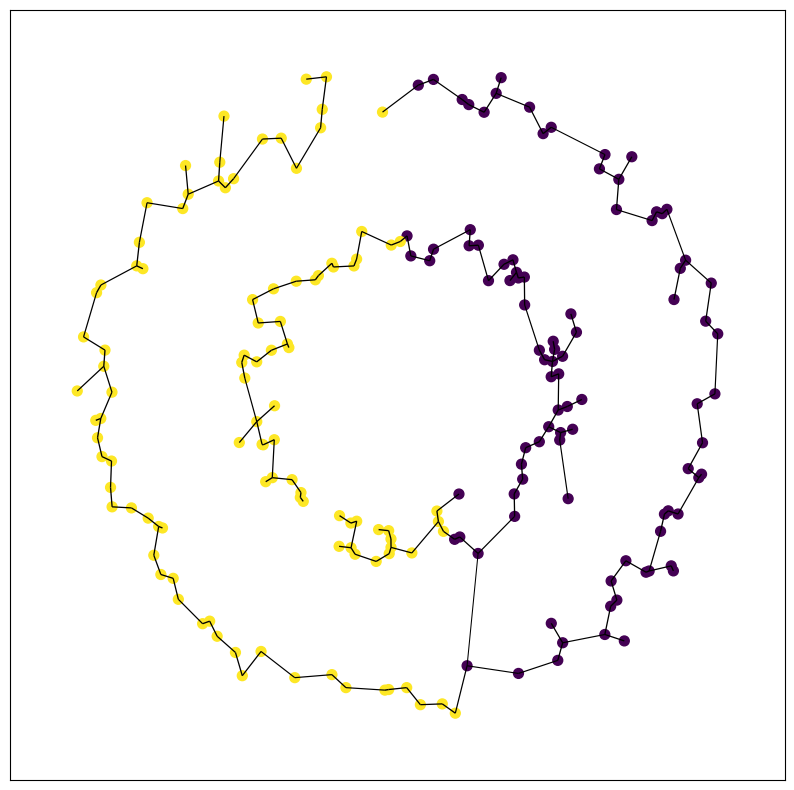

In [67]:
PCA_(setX, MST_G, cluster_labels_X_EM)

## spectral algorithm

In [68]:
spectral_clus = SpectralClustering(affinity='precomputed', n_clusters=2, random_state=42)

In [69]:
cluster_labels_X_spectral = spectral_clus.fit_predict(similar_matrix_X)

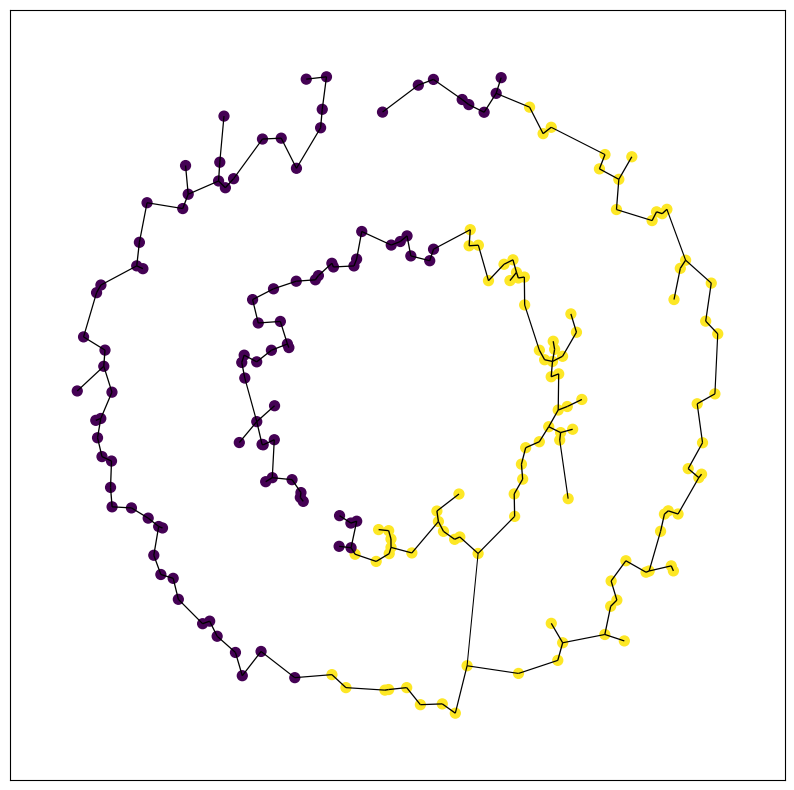

In [70]:
PCA_(setX, MST_G, cluster_labels_X_spectral)

## comparison clusters with RAND index

In [71]:
CLUSTERS_X = [cluster_labels_X_ward, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

def RAND_index(cluster1, cluster2):
    return f"RAND index = {adjusted_rand_score(cluster1, cluster2)}"


### ward & k-means

In [72]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[1])

'RAND index = 0.2239791857973676'

### ward & EM

In [73]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[2])

'RAND index = 0.18704323241722196'

### ward & spectral

In [74]:
RAND_index(CLUSTERS_X[0], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### k-means & EM

In [75]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[2])

'RAND index = 0.8824420658265663'

### k-means & spectral

In [76]:
RAND_index(CLUSTERS_X[1], CLUSTERS_X[3])

'RAND index = 0.5433623677559761'

### EM & spectral

In [77]:
RAND_index(CLUSTERS_X[2], CLUSTERS_X[3])

'RAND index = 0.48530342476523775'

### conclusions

+ 

## Modular func

In [78]:
cluster_labels_X_ward_new = [1 if label == 2 else 0 for label in cluster_labels_X_ward.copy()]

FOR_MODULAR = [cluster_labels_X_ward_new, cluster_labels_X_kmeans, cluster_labels_X_EM, cluster_labels_X_spectral]

In [79]:
def Modular_for_clust(cluster):
    nodes_cluster1 = [i for i, label in enumerate(cluster) if label == 0]
    nodes_cluster2 = [i for i, label in enumerate(cluster) if label == 1]

    partition = [
        nodes_cluster1,
        nodes_cluster2
    ]

    Q = nx.community.modularity(MST_G, partition)

    return Q

In [80]:
for cluster in FOR_MODULAR:
    print(Modular_for_clust(cluster))

0.48626512544317724
0.48019702068744763
0.47335868544952486
0.48022578432290886


# Кластеризация при k = 3

In [81]:
cluster_labels_X_ward_3 = fcluster(
    Z_X,
    t=3,
    criterion='maxclust'
)

cluster_labels_Y_ward_3 = fcluster(
    Z_Y,
    t=3,
    criterion='maxclust'
)

Из ранее построенной иерархической кластеризации (Ward linkage) извлекаем разбиение данных на 3 кластера. Метод использует матрицу расстояний и формирует компактные кластеры за счёт минимизации внутрикластерной дисперсии.

## k-means (k = 3)


In [82]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels_X_kmeans_3 = kmeans_3.fit_predict(data_scaled_X)

kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels_Y_kmeans_3 = kmeans_3.fit_predict(data_scaled_Y)

Алгоритм k-means применяется к стандартизированным данным и разбивает объекты на 3 кластера, минимизируя сумму квадратов расстояний до центров кластеров.

In [83]:
gmm_3 = GaussianMixture(n_components=3, random_state=42, n_init=10)
cluster_labels_X_EM_3 = gmm_3.fit_predict(data_scaled_X)

gmm_3 = GaussianMixture(n_components=3, random_state=42, n_init=10)
cluster_labels_Y_EM_3 = gmm_3.fit_predict(data_scaled_Y)

Аппроксимируем данные смесью трёх нормальных распределений. Каждому объекту присваивается кластер с максимальной апостериорной вероятностью принадлежности.

In [84]:
spectral_3 = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    random_state=42
)

cluster_labels_X_spectral_3 = spectral_3.fit_predict(similar_matrix_X)

spectral_3 = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    random_state=42
)
cluster_labels_Y_spectral_3 = spectral_3.fit_predict(similar_matrix_Y)

Спектральная кластеризация выполняется на основе матрицы сходства, построенной из графовой модели данных. Метод учитывает структуру связей между объектами

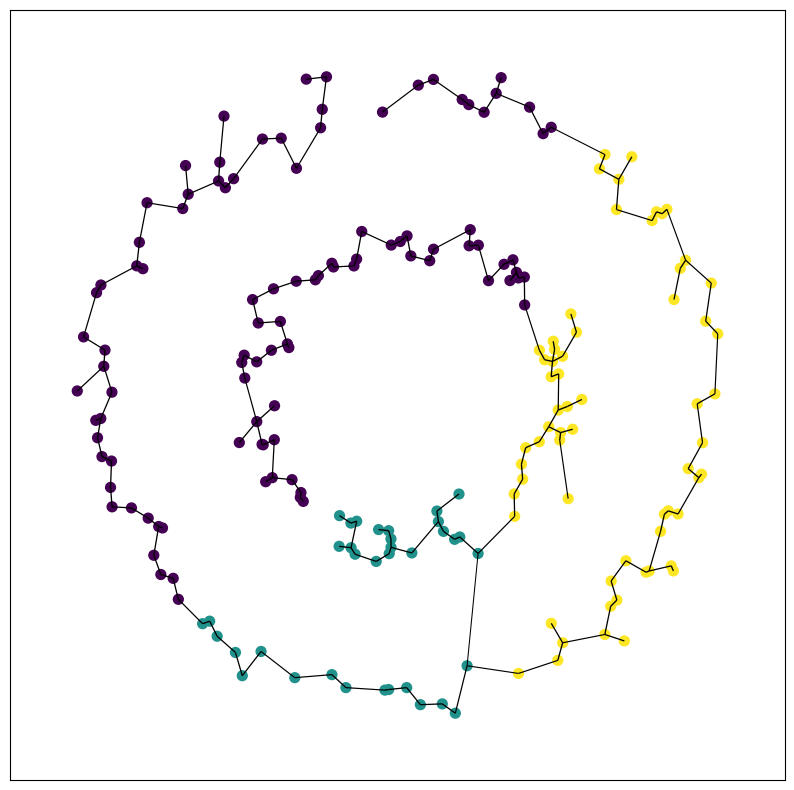

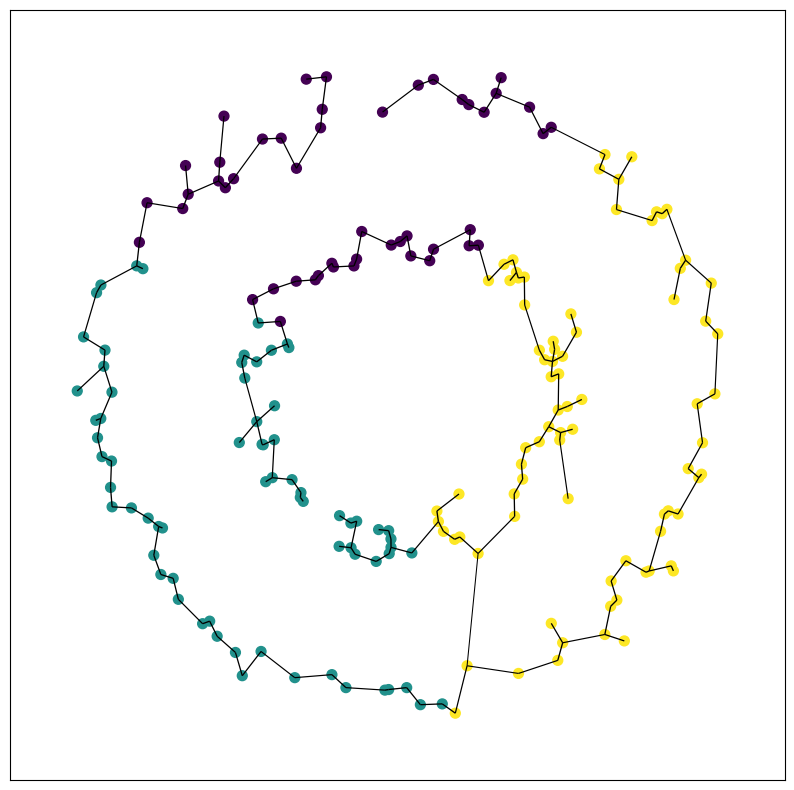

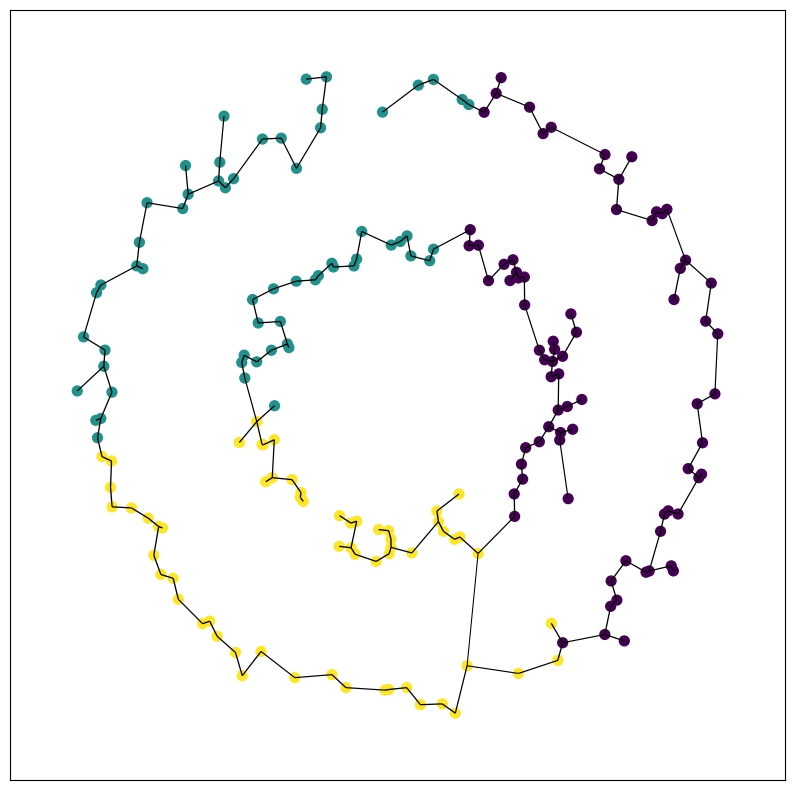

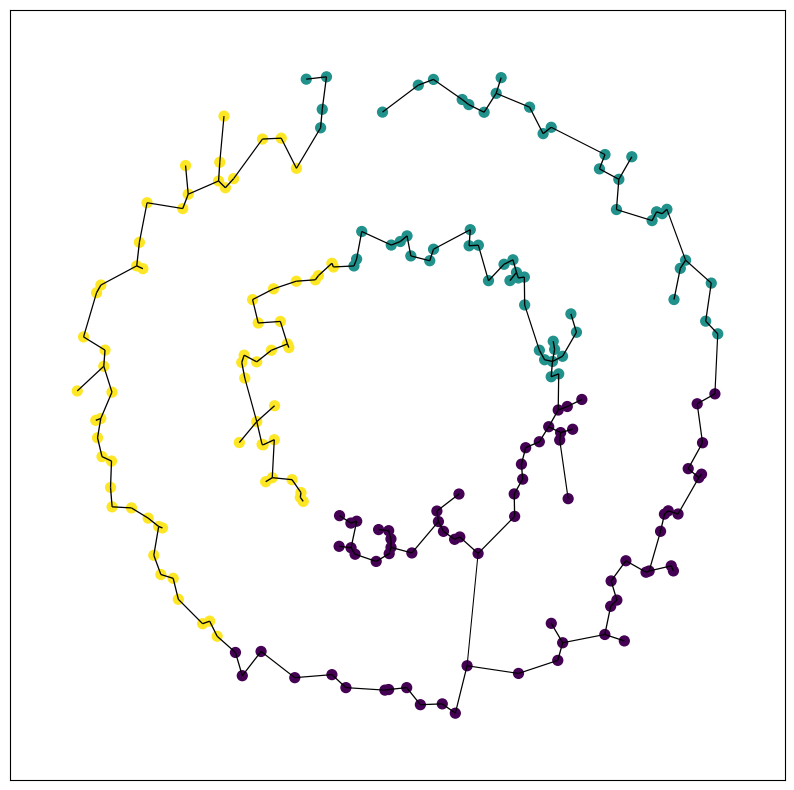

In [85]:
PCA_(setX, MST_G, cluster_labels_X_ward_3)
PCA_(setX, MST_G, cluster_labels_X_kmeans_3)
PCA_(setX, MST_G, cluster_labels_X_EM_3)
PCA_(setX, MST_G, cluster_labels_X_spectral_3)

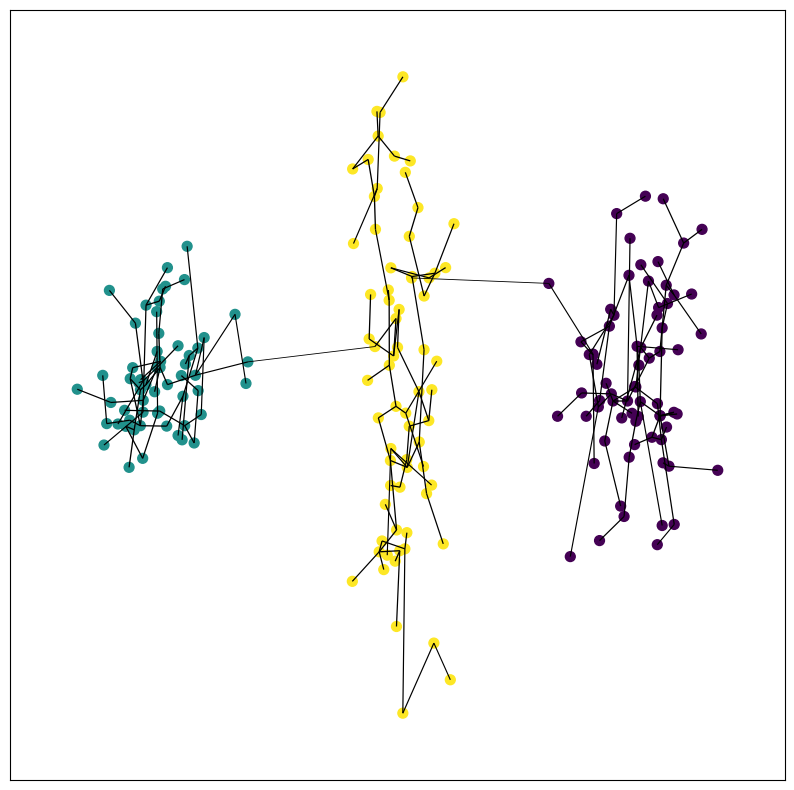

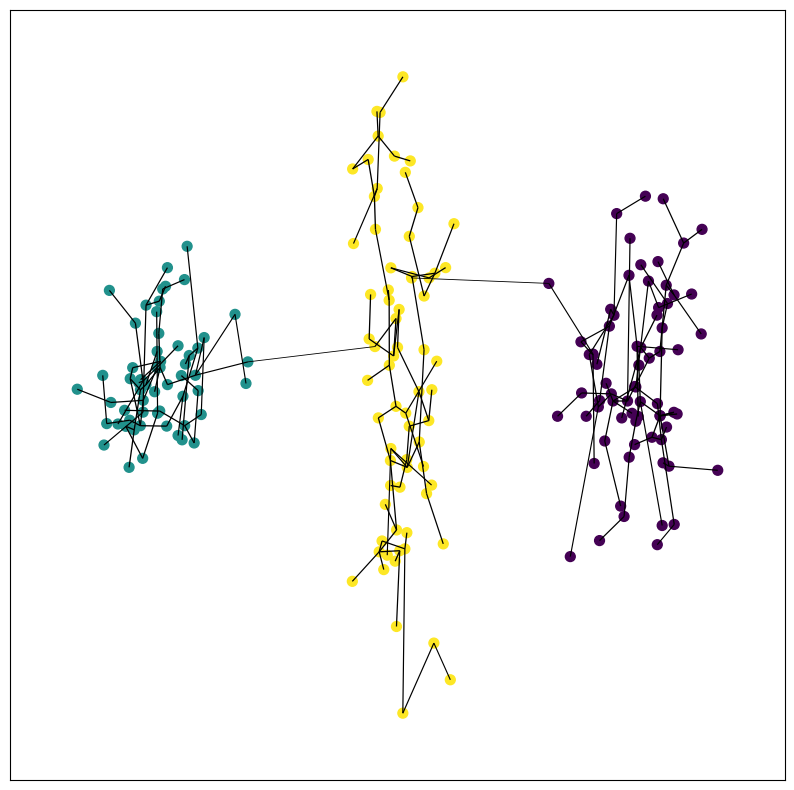

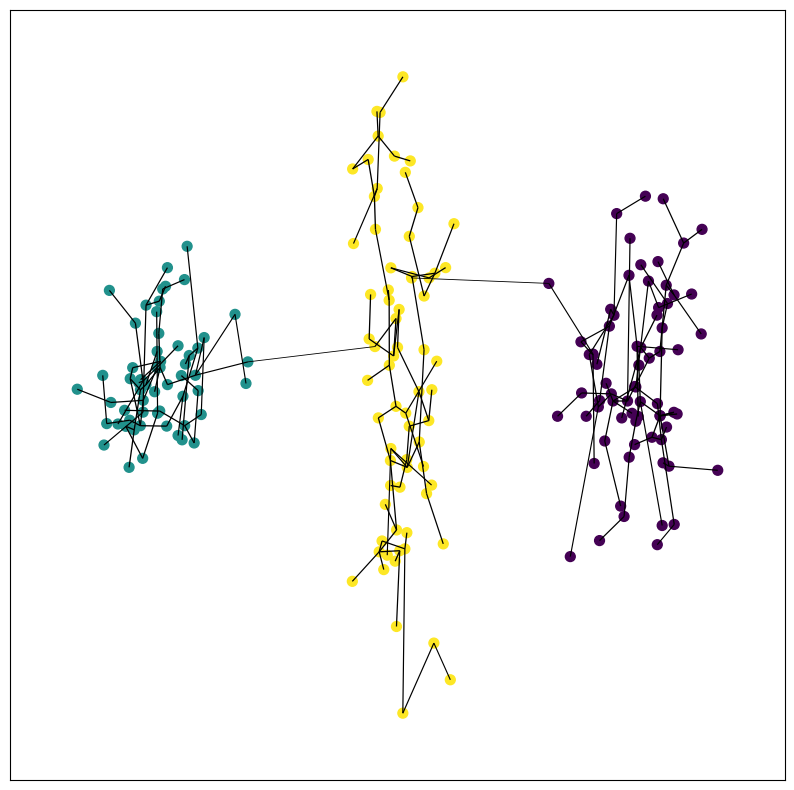

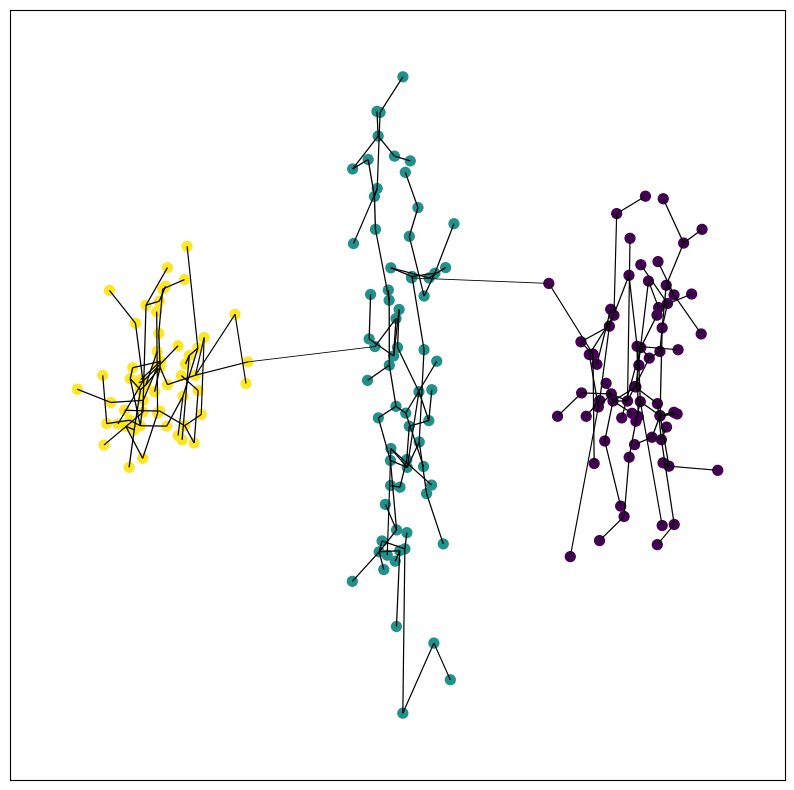

In [86]:
PCA_(setY, MST_G_Y, cluster_labels_Y_ward_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_kmeans_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_EM_3)
PCA_(setY, MST_G_Y, cluster_labels_Y_spectral_3)

Здесь мы визуализируем наши кластеры.

Сравнение кластеризаций (RAND index)

In [87]:
CLUSTERS_X_3 = [
    cluster_labels_X_ward_3,
    cluster_labels_X_kmeans_3,
    cluster_labels_X_EM_3,
    cluster_labels_X_spectral_3
]

names = ['Ward_X', 'KMeans_X', 'EM_X', 'Spectral_X']

In [88]:
CLUSTERS_Y_3 = [
    cluster_labels_Y_ward_3,
    cluster_labels_Y_kmeans_3,
    cluster_labels_Y_EM_3,
    cluster_labels_Y_spectral_3
]

names = ['Ward_Y', 'KMeans_Y', 'EM_Y', 'Spectral_Y']

Все полученные разбиения на 3 кластера объединяем в список для последующего сравнения и анализа качества кластеризации.

In [89]:
for i in range(len(CLUSTERS_X_3)):
    for j in range(i+1, len(CLUSTERS_X_3)):
        print(
            names[i], '&', names[j],
            RAND_index(CLUSTERS_X_3[i], CLUSTERS_X_3[j])
        )

Ward_Y & KMeans_Y RAND index = 0.4059036035541794
Ward_Y & EM_Y RAND index = 0.4499436224910902
Ward_Y & Spectral_Y RAND index = 0.3772878245806738
KMeans_Y & EM_Y RAND index = 0.5189626486837193
KMeans_Y & Spectral_Y RAND index = 0.29067749805281434
EM_Y & Spectral_Y RAND index = 0.2835433981625041


In [90]:
for i in range(len(CLUSTERS_Y_3)):
    for j in range(i+1, len(CLUSTERS_Y_3)):
        print(
            names[i], '&', names[j],
            RAND_index(CLUSTERS_Y_3[i], CLUSTERS_Y_3[j])
        )

Ward_Y & KMeans_Y RAND index = 1.0
Ward_Y & EM_Y RAND index = 1.0
Ward_Y & Spectral_Y RAND index = 1.0
KMeans_Y & EM_Y RAND index = 1.0
KMeans_Y & Spectral_Y RAND index = 1.0
EM_Y & Spectral_Y RAND index = 1.0


Для каждой пары кластеризаций вычисляется Adjusted RAND Index, характеризующий степень совпадения разбиений.

## Сделаем выводы для этих сравнений: 

Ward & KMeans

RAND ≈ 0.41

Разбиения имеют умеренное совпадение.
Это означает, что часть объектов Ward и k-means относят к одинаковым кластерам, однако в целом структура кластеров заметно различается из-за различия используемых подходов (иерархический vs центроидный).

Ward & EM

RAND ≈ 0.45

Сходство немного выше, чем с k-means.
Вероятностная модель EM в ряде случаев ближе к структуре, выявляемой иерархической кластеризацией, но различия всё ещё существенны.

Ward & Spectral

RAND ≈ 0.38

Низко-средний уровень совпадения.
Spectral clustering использует графовую модель данных, тогда как Ward работает в пространстве расстояний, что приводит к различным разбиениям.

KMeans & EM

RAND ≈ 0.52 (наибольшее значение)

Наиболее близкие разбиения среди всех пар.
Оба метода работают в пространстве признаков и ориентированы на компактные кластеры, что объясняет их высокую согласованность.

KMeans & Spectral

RAND ≈ 0.29

Низкое совпадение разбиений.
k-means игнорирует графовую структуру данных, тогда как Spectral clustering опирается на неё, что приводит к существенно разным результатам.

EM & Spectral

RAND ≈ 0.28

Минимальное совпадение среди всех пар.
Методы используют принципиально разные модели данных (вероятностную и графовую), поэтому полученные кластеры существенно различаются.

### То есть, что мы имеем: 
- Наиболее согласованные разбиения дают k-means и EM

- Spectral clustering формирует разбиения, значительно отличающиеся от методов, работающих в пространстве признаков

- Ward занимает промежуточное положение, частично согласуясь с k-means и EM

- В целом, при k = 3 наблюдается низкая устойчивость разбиений, что указывает на неоднозначность структуры данных для такого числа кластеров

## Модулярность для k = 3

In [91]:
def modularity_for_3_clusters(cluster_labels, G):
    clusters = []
    for c in np.unique(cluster_labels):
        clusters.append([i for i, label in enumerate(cluster_labels) if label == c])

    return nx.community.modularity(G, clusters)


In [92]:
for name, cl in zip(names, CLUSTERS_X_3):
    print(name, modularity_for_3_clusters(cl, MST_G))

Ward_Y 0.5937068334030926
KMeans_Y 0.6118644227562136
EM_Y 0.6217587223686878
Spectral_Y 0.6404529567246587


In [93]:
for name, cl in zip(names, CLUSTERS_Y_3):
    print(name, modularity_for_3_clusters(cl, MST_G_Y))

Ward_Y 0.6576635058079665
KMeans_Y 0.6576635058079665
EM_Y 0.6576635058079665
Spectral_Y 0.6576635058079665


Для каждого алгоритма кластеризации рассчитывается модулярность, позволяющая оценить согласованность разбиения со структурой графа MST.

Все методы дают достаточно высокие значения модулярности, что говорит о наличии кластерной структуры в данных. Spectral clustering лучше всего соответствует графовой структуре данных. EM и k-means занимают промежуточное положение. Ward наименее согласованна с графом среди рассмотренных методов.

Совместно с результатами RAND индекса это указывает на то, что при k = 3 структура кластеров сильно зависит от выбранного алгоритма, а графовые методы выявляют иную организацию данных, чем методы, работающие в пространстве признаков.

## Общий случай

Определение числа кластеров
Метод «локтя» (Elbow method)

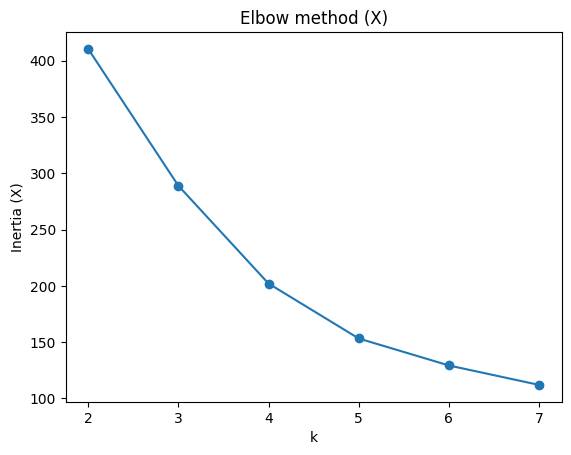

In [94]:
inertia_X = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(data_scaled_X)
    inertia_X.append(km.inertia_)

plt.plot(K, inertia_X, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (X)")
plt.title("Elbow method (X)")
plt.show()

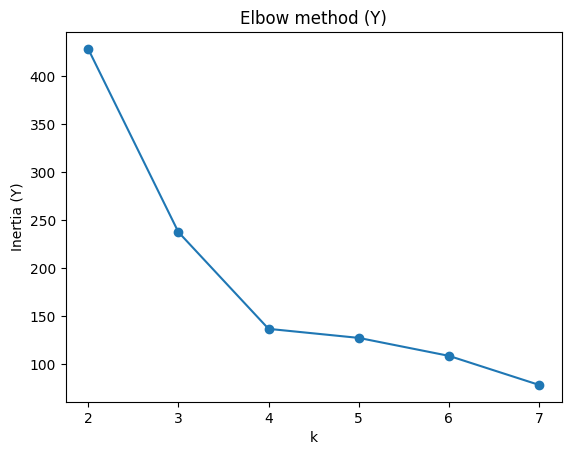

In [95]:
inertia_Y = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(data_scaled_Y)
    inertia_Y.append(km.inertia_)

plt.plot(K, inertia_Y, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia (Y)")
plt.title("Elbow method (Y)")
plt.show()

Вычисляется внутрикластерная сумма квадратов расстояний для разных значений числа кластеров с целью выявления оптимального k. По форме графика мы можем определить точку излома, соответствующую разумному числу кластеров в данных.

На графике мы показываем зависимость inertia (суммы внутрикластерных квадратов расстояний) от числа кластеров k.

- При увеличении k значение inertia монотонно уменьшается, так как кластеры становятся меньше.

- Наиболее резкое уменьшение inertia наблюдаем при переходе от k = 2 к k = 3 и от k = 3 к k = 4.

- Начиная с k = 4, снижение inertia замедляется и кривая становится более пологой.

Точка излома (локоть) графика находится в области k = 3–4.
Это означает, что дальнейшее увеличение числа кластеров даёт лишь незначительное улучшение качества кластеризации.

## Попробуем альтернативный метод: Silhouette score

Silhouette score оценивает компактность кластеров и их отделимость друг от друга, позволяя сравнить качество кластеризации при разных k.

Silhouette score характеризует качество кластеризации, учитывая одновременно компактность кластеров и отделимость кластеров друг от друга.

Значения лежат в диапазоне от −1 до 1, и чем больше значение, тем лучше качество кластеризации.

In [96]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(data_scaled_X)
    print(k, silhouette_score(data_scaled_X, labels))

2 0.42213388946044406
3 0.38978003486709556
4 0.3858792498306555
5 0.3793526217551415


In [97]:
for k in range(2, 6):
    labels = KMeans(n_clusters=k, random_state=42, n_init='auto').fit_predict(data_scaled_Y)
    print(k, silhouette_score(data_scaled_Y, labels))

2 0.45677742854869186
3 0.5350395937954092
4 0.5718383228244376
5 0.46026251726606443


Сравниваем качество кластеризации при k = 2 и k = 3, что позволяет подтвердить или опровергнуть выводы о предпочтительном числе кластеров.

Сделаем краткие выводы:

- Наибольшее значение silhouette score достигается при k = 2. 

- При увеличении числа кластеров значение показателя монотонно уменьшается.

- Это означает, что при k > 2 кластеры становятся менее компактными и хуже отделёнными друг от друга.

Таким образом, с точки зрения silhouette score, разбиение на 2 кластера является наиболее качественным.
Разбиение на 3 и более кластеров приводит к ухудшению качества кластеризации.

In [98]:
sil_kmeans_2 = silhouette_score(data_scaled_X, cluster_labels_X_kmeans)
sil_kmeans_3 = silhouette_score(data_scaled_X, cluster_labels_X_kmeans_3)

print("Silhouette k=2:", sil_kmeans_2)
print("Silhouette k=3:", sil_kmeans_3)

Silhouette k=2: 0.42213388946044406
Silhouette k=3: 0.38978003486709556


In [99]:
sil_kmeans_Y_2 = silhouette_score(data_scaled_Y, cluster_labels_Y_kmeans)
sil_kmeans_Y_3 = silhouette_score(data_scaled_Y, cluster_labels_Y_kmeans_3)

print("Silhouette Y k=2:", sil_kmeans_Y_2)
print("Silhouette Y k=3:", sil_kmeans_Y_3)

Silhouette Y k=2: 0.45677742854869186
Silhouette Y k=3: 0.5350395937954092


Большее значение silhouette score при k = 2 указывает на то, что кластеры в этом случае являются более компактными и лучше отделёнными друг от друга. Мы получили, что разбиение на 3 кластера приводит к ухудшению качества кластеризации, а это подтверждает вывод о том, что двухкластерная структура данных является более естественной и устойчивой.

### conclutions

+

## general conclutions

+
